## SVR (Support Vector Regression) Model

### Imports

In [13]:
# Imports:
import pandas as pd
import glob
import os
from IPython.display import display
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


### Data

In [14]:
# dfs = {}
# folder_path_23 = "/Users/evanellington/Downloads/CS 230/Project Data/2023"
# csv_files_23 = glob.glob(os.path.join(folder_path_23, "*.csv"))

# for f in csv_files_23:
#     key = os.path.splitext(os.path.basename(f))[0]
#     dfs[key] = pd.read_csv(f, encoding="ISO-8859-1")

# # Load 2024 Data
# dfs_24 = {}
# folder_path_24 = "/Users/evanellington/Downloads/CS 230/Project Data/2024"
# csv_files_24 = glob.glob(os.path.join(folder_path_24, "*.csv"))

# for f in csv_files_24:
#     key = os.path.splitext(os.path.basename(f))[0]
#     dfs_24[key] = pd.read_csv(f, encoding="ISO-8859-1")

### Model

In [ ]:

# Load 2024 Data
dfs = {}
folder_path_23 = "/Users/evanellington/Downloads/CS 230/Project Data/2023"
csv_files_23 = glob.glob(os.path.join(folder_path_23, "*.csv"))

for f in csv_files_23:
    key = os.path.splitext(os.path.basename(f))[0]
    dfs[key] = pd.read_csv(f, encoding="ISO-8859-1")

# Load 2024 Data
dfs_24 = {}
folder_path_24 = "/Users/evanellington/Downloads/CS 230/Project Data/2024"
csv_files_24 = glob.glob(os.path.join(folder_path_24, "*.csv"))

for f in csv_files_24:
    key = os.path.splitext(os.path.basename(f))[0]
    dfs_24[key] = pd.read_csv(f, encoding="ISO-8859-1")

# Load 2025 Data
dfs_25 = {}
folder_path_25 = "/Users/evanellington/Downloads/CS 230/Project Data/2025"
csv_files_25 = glob.glob(os.path.join(folder_path_25, "*.csv"))

for f in csv_files_24:
    key = os.path.splitext(os.path.basename(f))[0]
    dfs_24[key] = pd.read_csv(f, encoding="ISO-8859-1")

# -----------------------------
# Helper Functions
# -----------------------------
def merge_seasons(df_2023, df_2024, player_col='Player'):
    df_2023 = df_2023.add_suffix('_2023')
    df_2024 = df_2024.add_suffix('_2024')
    merged = pd.merge(df_2024, df_2023,
                      left_on=f'{player_col}_2024',
                      right_on=f'{player_col}_2023',
                      how='left')
    merged['player_name'] = merged[f'{player_col}_2024']
    merged['ADP'] = merged['ADP_2024']
    merged.drop([f'{player_col}_2024', f'{player_col}_2023'], axis=1, inplace=True)
    return merged

def clean_numeric(df, target):
    """Convert all columns to numeric, drop rows with NaNs in features or target."""
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    # Ensure target is numeric
    df[target] = pd.to_numeric(df[target], errors='coerce')
    # Convert numeric columns to numeric (coerce errors)
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    # Drop rows with NaN in target or features
    df = df.dropna(subset=numeric_cols + [target])
    return df, numeric_cols

def train_position_model(df, features, target):
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target],
                                                        test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svr = SVR(kernel='rbf', C=10, epsilon=0.5)
    svr.fit(X_train_scaled, y_train)
    
    y_pred = svr.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"R2 Score: {r2:.3f}, RMSE: {rmse:.4f}")
    
    return svr, scaler

def predict_position(df, model, scaler, features):
    X_scaled = scaler.transform(df[features])
    df['predicted_2025_fp'] = model.predict(X_scaled)

    # Add columns required for snake draft
    df['FantasyPoints'] = df['FantasyPoints_2024']  # use last season’s actual points
    return df

# -----------------------------
# Train Models Per Position
# -----------------------------
positions = {
    'QB': ('2023_Stats(QBs)', '2024_Stats(QBs)'),
    'RB': ('2023_Stats(RBs)', '2024_Stats(RBs)'),
    'WR': ('2023_Stats(WRs)', '2024_Stats(WRs)'),
    'TE': ('2023_Stats(TEs)', '2024_Stats(TEs)'),
    'K':  ('2023_Stats(Ks)', '2024_Stats(Ks)'),
    'DST':('2023_Stats(DSTs)', '2024_Stats(DSTs)')
}

predicted_dfs = []
position_models = {}
scalers = {}

for pos, (df23_key, df24_key) in positions.items():
    df_2023 = dfs[df23_key]
    df_2024 = dfs_24[df24_key]
    
    merged_df = merge_seasons(df_2023, df_2024, player_col='Name')
    
    # Clean data and get numeric features
    target = 'FantasyPoints_2024'  # make sure this matches your CSV column
    merged_df, numeric_features = clean_numeric(merged_df, target)
    if target in numeric_features:
        numeric_features.remove(target)
    
    print(f"\nTraining {pos} model...")
    model, scaler = train_position_model(merged_df, numeric_features, target)
    
    merged_df = predict_position(merged_df, model, scaler, numeric_features)

    merged_df['position'] = pos
    
    predicted_dfs.append(merged_df)
    position_models[pos] = model
    scalers[pos] = scaler

# -----------------------------
# Combine All Positions Into Draft Board
# -----------------------------
draft_board = pd.concat(predicted_dfs, ignore_index=True)
draft_board.rename(columns={'predicted_2025_fp': 'Predicted_2025_FP'}, inplace=True)

draft_board = draft_board.sort_values('Predicted_2025_FP', ascending=False)

# Show the columns needed for snake draft
print(draft_board[['player_name', 'position', 'Predicted_2025_FP', 'FantasyPoints', 'ADP']].head(20))



Training QB model...
R2 Score: 0.058, RMSE: 162.1426

Training RB model...
R2 Score: 0.426, RMSE: 79.7823

Training WR model...
R2 Score: 0.324, RMSE: 63.9000

Training TE model...
R2 Score: 0.514, RMSE: 44.4443

Training K model...
R2 Score: 0.794, RMSE: 12.1935

Training DST model...
R2 Score: 0.275, RMSE: 21.5254
            player_name position  Predicted_2025_FP  FantasyPoints    ADP
153      Terry McLaurin       WR         216.529081          267.8   64.5
152        Drake London       WR         214.903288          281.1   21.0
155  Jaxon Smith-Njigba       WR         213.539741          253.0   97.5
156      Garrett Wilson       WR         213.412351          251.9   12.5
157    Courtland Sutton       WR         213.143112          242.2  109.0
159         Jerry Jeudy       WR         212.940030          240.9  138.5
158       Davante Adams       WR         211.537171          241.3   21.5
161            DJ Moore       WR         209.113647          238.7   38.5
169         Zay

### Snake Draft

In [ ]:
def get_best_available(player_pool, current_roster=None, sort_column='ADP'):
    """
    Returns the best available player based on the given sort_column.
    """
    available = player_pool[player_pool['Drafted'] == False]

    # Sort ascending for ADP, descending for projections
    if sort_column.upper() == 'ADP':
        available = available.sort_values(by='ADP', ascending=True)
    else:
        available = available.sort_values(by=sort_column, ascending=False)

    return available.iloc[0]

# Max limits for roster
ROSTER_LIMITS = {
    'QB': 2,
    'RB': 6,
    'WR': 6,
    'TE': 2,
    'K': 1,
    'DST': 1
}

# Min requirements for roster
MINIMUM_REQUIRED = {
    'QB': 1,
    'RB': 1,
    'WR': 1,
    'TE': 1,
    'K': 1,
    'DST': 1
}


def plot_model_vs_all_opponents_histogram(model_scores, all_opp_scores, model_name="NN"):
    """
    Plot histogram of model team scores and overlay all individual opponent scores,
    plus shaded regions showing their score ranges.
    """

    # Flatten opponent scores
    flattened_opp_scores = [score for sim_scores in all_opp_scores for score in sim_scores]

    # Compute ranges
    model_min, model_max = min(model_scores), max(model_scores)
    opp_min, opp_max     = min(flattened_opp_scores), max(flattened_opp_scores)

    plt.figure(figsize=(12, 7))

    # --- Shaded Range for Model Scores ---
    plt.axvspan(model_min, model_max, color='blue', alpha=0.1, label=f"{model_name} Score Range")

    # --- Shaded Range for Opponent Scores ---
    plt.axvspan(opp_min, opp_max, color='orange', alpha=0.1, label="Opponent Score Range")

    # --- Histograms ---
    plt.hist(model_scores, bins=20, alpha=0.6, color='blue', label=f'{model_name} Team Scores')
    plt.hist(flattened_opp_scores, bins=20, alpha=0.6, color='orange', label='All Opponent Scores')

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.xlabel("Total Fantasy Points", fontsize = 18)
    plt.ylabel("Frequency", fontsize = 18)
    plt.legend(loc="upper left", fontsize = 18)
    plt.tight_layout()
    plt.show()

In [17]:
def run_svr_snake_draft(master_pool, num_simulations=200, num_teams=12, rounds=15):
    required_cols = ['FantasyPoints', 'Predicted_2025_FP', 'ADP', 'position']
    for col in required_cols:
        if col not in master_pool.columns:
            raise KeyError(f"Master pool is missing required column: '{col}'")

    master_pool = master_pool.copy()
    master_pool['FantasyPoints'] = pd.to_numeric(master_pool['FantasyPoints'], errors='coerce').fillna(0)
    master_pool['Predicted_2025_FP'] = pd.to_numeric(master_pool['Predicted_2025_FP'], errors='coerce').fillna(0)
    master_pool['ADP'] = pd.to_numeric(master_pool['ADP'], errors='coerce').fillna(999.0)

    print("Running SVR snake-draft simulations...")

    model_scores = []
    baseline_scores = []
    all_opponent_scores = []
    last_sim_teams = None
    model_wins = 0  # Track number of simulations where the model won

    for sim in range(num_simulations):
        model_slot = np.random.randint(0, num_teams)
        player_pool = master_pool.copy()
        player_pool['Drafted'] = False
        teams = {i: [] for i in range(num_teams)}

        for round_num in range(rounds):
            order = list(range(num_teams)) if round_num % 2 == 0 else list(reversed(range(num_teams)))
            for team_idx in order:
                roster = teams[team_idx]
                sort_col = 'Predicted_2025_FP' if team_idx == model_slot else 'ADP'

                # Count players by position
                pos_counts = {pos: sum(p['position'] == pos for p in roster) for pos in ROSTER_LIMITS}

                available_players = player_pool[player_pool['Drafted'] == False].copy()

                # Enforce maximums for all teams
                for pos, max_limit in ROSTER_LIMITS.items():
                    if pos_counts.get(pos, 0) >= max_limit:
                        available_players = available_players[available_players['position'] != pos]

                # Enforce minimums only for last picks of a team
                remaining_picks = rounds - len(roster)
                positions_needed = []
                if remaining_picks <= 2:  # last 2 picks
                    positions_needed = [pos for pos, min_req in MINIMUM_REQUIRED.items()
                        if pos_counts.get(pos, 0) < min_req]
                    if positions_needed:
                        available_players = available_players[available_players['position'].isin(positions_needed)]

                if available_players.empty:
                    continue

                TOP_N_OPPONENT = 5  # opponents pick randomly from top 3 available by ADP

                if sort_col == 'ADP':
                    top_n = available_players.sort_values(by='ADP', ascending=True).head(TOP_N_OPPONENT)
                    pick = top_n.sample(n=1).iloc[0]  # pick randomly from top N
                else:
                    pick = available_players.sort_values(by='Predicted_2025_FP', ascending=False).iloc[0]


                player_pool.loc[pick.name, 'Drafted'] = True
                teams[team_idx].append(pick)

        # Scoring
        model_team_df = pd.DataFrame(teams[model_slot])
        model_score = model_team_df['FantasyPoints'].sum()
        model_scores.append(model_score)

        opp_scores = []
        for opp in range(num_teams):
            if opp != model_slot:
                opp_df = pd.DataFrame(teams[opp])
                opp_scores.append(opp_df['FantasyPoints'].sum())
        all_opponent_scores.append(opp_scores)
        baseline_avg = np.mean(opp_scores)
        baseline_scores.append(baseline_avg)

        if model_score > max(opp_scores):
            model_wins += 1

        if sim == num_simulations - 1:
            last_sim_teams = {k: pd.DataFrame(v) for k, v in teams.items()}

    avg_model = np.mean(model_scores)
    avg_baseline = np.mean(baseline_scores)
    diff = avg_model - avg_baseline

    print("\n==============================")
    print("    FINAL SNAKE-DRAFT RESULTS")
    print("==============================")
    print(f"Avg Model Score:    {avg_model:.2f}")
    print(f"Avg Opponent Score: {avg_baseline:.2f}")
    print(f"Advantage:          {diff:.2f} points")
    print(f"Model Won {model_wins}/{num_simulations} simulations")
    print("==============================")

    # Print last simulation teams
    print("\n=== Last Simulation Drafted Teams ===")
    for team_idx, df in last_sim_teams.items():
        team_label = f"Team {team_idx + 1}"
        if team_idx == model_slot:
            team_label += " (SVR Model's Team)"
        total_fp = df['FantasyPoints'].sum() if not df.empty else 0
        print(f"\n{team_label} — Total Projected Fantasy Points: {total_fp:.2f}")
        if not df.empty:
            print(df[['player_name', 'position', 'Predicted_2025_FP', 'FantasyPoints', 'ADP']])
        else:
            print("No players drafted")

    return {
        "avg_model": avg_model,
        "avg_baseline": avg_baseline,
        "difference": diff,
        "model_wins": model_wins,
        "last_sim_teams": last_sim_teams,
        "baseline_scores": baseline_scores,
        "model_scores": model_scores,
        "all_opponent_scores": all_opponent_scores
    }


In [21]:
svr_results = run_svr_snake_draft(draft_board, num_simulations=100)

Running SVR snake-draft simulations...

    FINAL SNAKE-DRAFT RESULTS
Avg Model Score:    3102.43
Avg Opponent Score: 2687.65
Advantage:          414.78 points
Model Won 49/100 simulations

=== Last Simulation Drafted Teams ===

Team 1 — Total Projected Fantasy Points: 2965.30
             player_name position  Predicted_2025_FP  FantasyPoints    ADP
151     Justin Jefferson       WR         186.771228          317.4    5.5
154          CeeDee Lamb       WR         194.023152          263.4    2.5
186         Deebo Samuel       WR         154.996642          154.7   26.5
89             Joe Mixon       RB         184.535800          240.5   42.0
97        Kenneth Walker       RB         163.624859          181.5   40.0
217       Christian Kirk       WR         109.967253           71.0   67.5
162          Tee Higgins       WR         188.793323          222.1   60.5
167       Jordan Addison       WR         190.725643          212.5  100.5
4             Jared Goff       QB         142.5

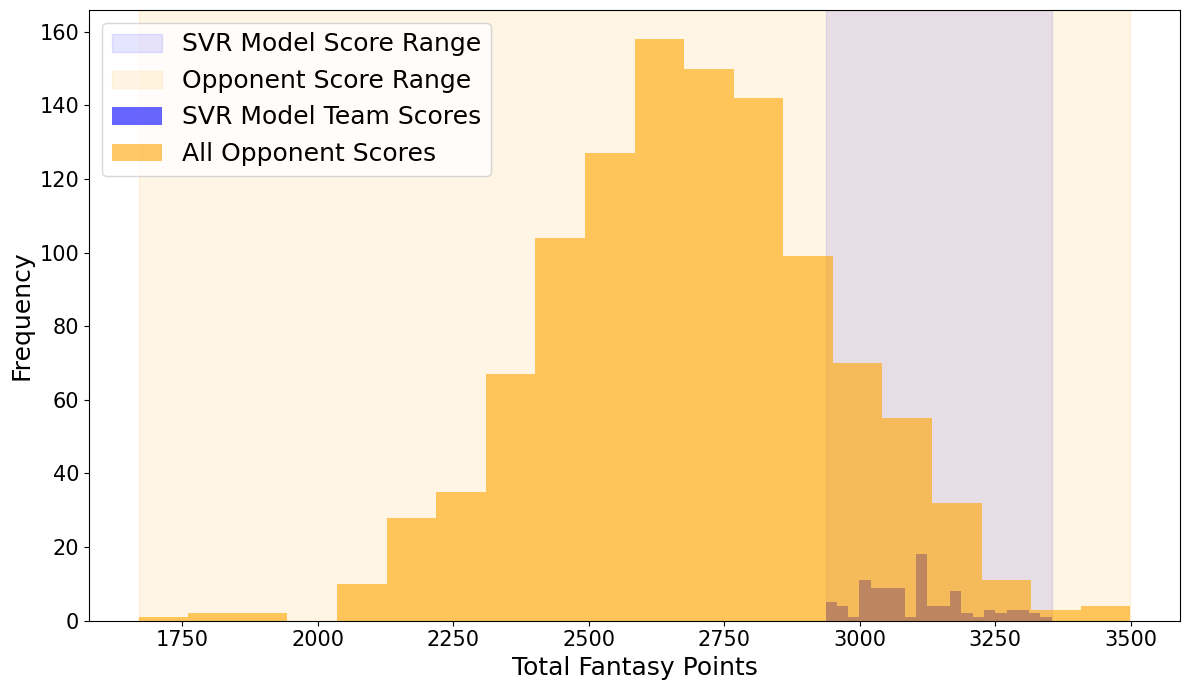

In [22]:
plot_model_vs_all_opponents_histogram(
    svr_results["model_scores"],
    svr_results["all_opponent_scores"],
    model_name="SVR Model"
)

In [23]:
def compute_score_distribution_gap(model_scores, all_opp_scores):
    """
    Computes the gap between the lower bound of the model score distribution 
    and the upper bound of the opponent score distribution.

    Gap = min(model_scores) - max(opponent_scores)

    A positive gap means the two distributions DO NOT overlap.
    A negative gap means they DO overlap.
    """

    # Flatten opponent scores
    flattened_opp_scores = [s for sim in all_opp_scores for s in sim]

    # Compute bounds
    model_low = min(model_scores)
    opp_high = max(flattened_opp_scores)

    # Compute the gap
    gap = model_low - opp_high

    print("Lowest model score:      ", model_low)
    print("Highest opponent score:  ", opp_high)
    print("Score distribution gap:  ", gap)

    return gap

gap_value = compute_score_distribution_gap(svr_results["model_scores"], svr_results["all_opponent_scores"])
print("Final gap:", gap_value)

Lowest model score:       2936.7000000000007
Highest opponent score:   3499.2000000000003
Score distribution gap:   -562.4999999999995
Final gap: -562.4999999999995
